# Forecasting Volatility with Random Forest

### Thomas Polstra, PhD

##### [GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)

## Notebook Overview

1. Data Preparation
   - Gather returns for either an asset or a strategy.

2. Traditional Volatility Models
   - GARCH(1,1)
   - Historical 23 day 95% volatility

3. Random Forest for Volatility Forecasting
   - Overvies of Random Forest
   - Feature Selection

4. Building and Evaluating the Random Forest Model
   - Implement Random Forest algorithm for volatility forecasting.
   - Evaluate model performance.

In [84]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from arch import arch_model
import numpy as np
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

[*********************100%***********************]  1 of 1 completed


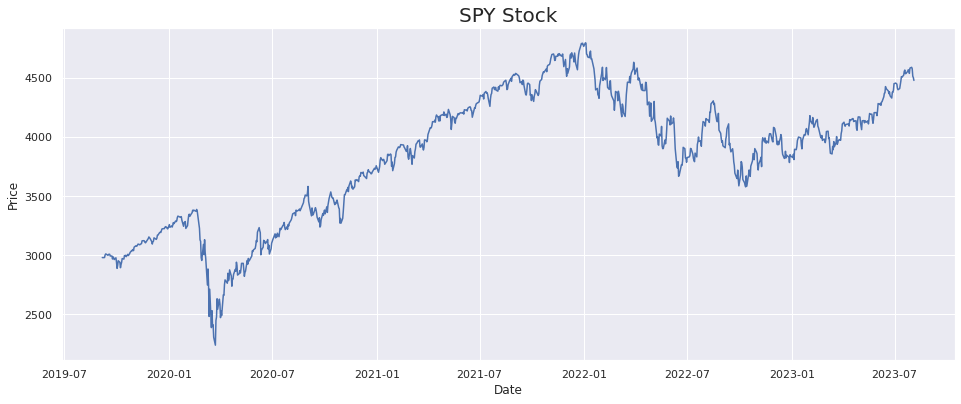

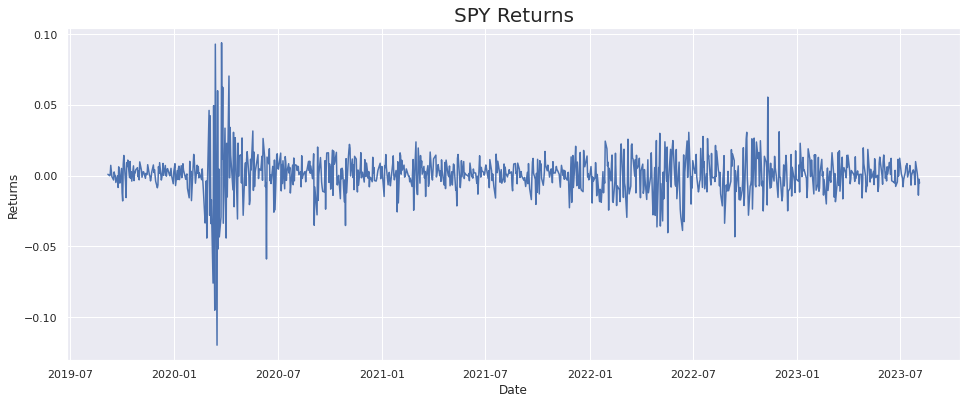

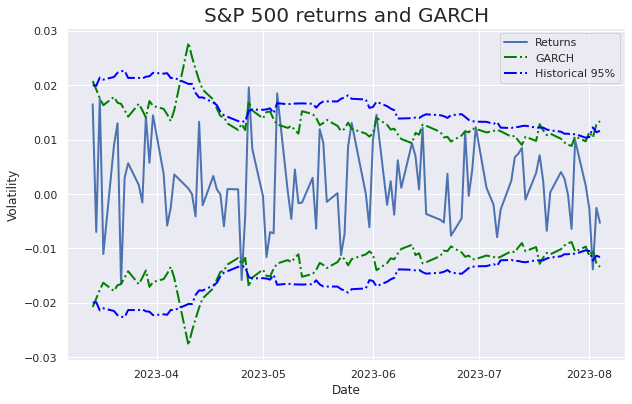

In [79]:
# Define the ticker symbol for the S&P 500 index
ticker = '^GSPC'

# Define the date range for the last 18 months
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(months=48)

# Retrieve the stock data for the S&P 500 index from Yahoo Finance
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data['returns'] = stock_data['Adj Close'].pct_change()
stock_data['95%_historical_cofidence_volatility'] = stock_data['returns'].rolling(23).std()*1.96
stock_data = stock_data.dropna()


# Data Visualization
plt.plot(stock_data['Adj Close'])
plt.title(f'SPY Stock', size = 20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.plot(stock_data['returns'].dropna())
plt.title(f'SPY Returns', size = 20)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()



#GARCH(1,1) volatility modeling for SPY index

returns_data = stock_data['returns'].dropna()

#Split Data into Training and Testing Sets
testing_set = returns_data.iloc[-100:]
training_set = returns_data.iloc[:-100]


# Perform GARCH Modeling on the Training Set
# Rescale the data (multiply by 100)
training_set_scaled = training_set * 100

# Fit the GARCH(1,1) model to the rescaled training set
garch_model = arch_model(training_set_scaled, vol='Garch', p=1, q=1)
results = garch_model.fit(disp='off')

# Calculate GARCH volatility for the testing set
garch_volatility_rescaled = results.conditional_volatility[-100:]/100

# Plotting the Results
plt.figure(figsize=(10, 6))
plt.plot(testing_set.index, testing_set, label='Returns', linewidth=2)
plt.plot(testing_set.index, -garch_volatility_rescaled, label='GARCH', linestyle='-.', linewidth=2, color = 'green')
plt.plot(testing_set.index, garch_volatility_rescaled, linestyle='-.', linewidth=2, color = 'green')
plt.plot(testing_set.index, -stock_data['95%_historical_cofidence_volatility'][-100:], label='Historical 95%', linestyle='-.', linewidth=2, color = 'blue')
plt.plot(testing_set.index, stock_data['95%_historical_cofidence_volatility'][-100:], linestyle='-.', linewidth=2, color = 'blue')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('S&P 500 returns and GARCH', size = 20)
plt.legend()
plt.show()





## Remarks about Random Forest Machine Learning

- Random Forest is an ensemble learning method widely used in machine learning for classification and regression tasks.
- It is based on the idea of combining multiple decision trees to create a more robust and accurate prediction model.
- Random Forest is known for its high accuracy, versatility, and resistance to overfitting.

## How Random Forest Works

1. **Ensemble Learning**: Random Forest is an example of ensemble learning, where multiple weak learners (individual decision trees) are combined to create a strong learner (the random forest).

2. **Bootstrap Aggregating (Bagging)**: The process starts by randomly selecting subsets of the training data (with replacement). Each subset is called a bootstrap sample, and it is used to train a separate decision tree.

3. **Random Feature Selection**: At each node of the decision tree, a random subset of features is considered for splitting. This randomization helps reduce the correlation between trees and promotes diversity.

4. **Decision Tree Building**: Each decision tree is constructed using the bootstrap sample and random feature set. The tree is grown until a stopping criterion is met, typically when a certain depth is reached or the leaf nodes contain a minimum number of samples.

5. **Voting and Averaging**: For classification tasks, the final prediction is made by majority voting among all the decision trees. For regression tasks, the final prediction is obtained by averaging the predictions of all trees.

## Advantages of Random Forest

1. **High Accuracy**: Random Forest generally yields high accuracy due to its ensemble nature and ability to capture complex patterns in the data.

2. **Robustness**: It is less prone to overfitting compared to individual decision trees.

3. **Versatility**: Random Forest can handle both classification and regression tasks.

4. **Feature Importance**: It provides a measure of feature importance, indicating which features are most relevant for the prediction.

5. **Parallelization**: The training of decision trees can be easily parallelized, making it efficient for large datasets.

## Limitations of Random Forest

1. **Black Box Model**: Interpretability can be a challenge, as the combined decision of multiple trees can be complex to understand.

2. **Data with Many Features**: Random Forest may not perform well on datasets with a large number of features.

3. **Overfitting Risk**: Although less prone to overfitting, it can still occur if the number of trees is too large.

**Summary**

Random Forest is a powerful machine learning algorithm that leverages the strength of decision trees and ensemble learning to achieve high accuracy and robustness. By combining multiple decision trees and randomizing feature selection, Random Forest is effective in various applications, including classification, regression, and feature importance analysis.

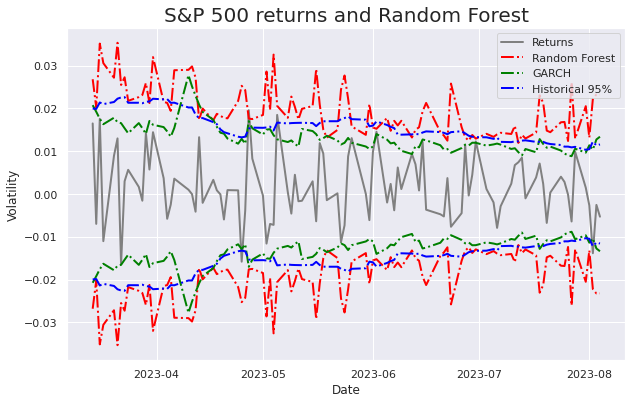

Root of mean squared error of the GARCH(1,1) 95% cofidence interval: 0.006023980321486986
---
---
Root Mean Squared Error Random Forest: 0.004702715485182993
---
---
GARCH(1,1) outperformed Random Forest on the Test Set


In [85]:
# We use Random Forest to estimate the 95% cofidence interval for volatility



# Split Data into Training and Testing Sets
# Assuming you have the testing set as the last 23 data points of the features_df
training_set = stock_data.iloc[:-100]
testing_set = stock_data.iloc[-100:]


# Train the Random Forest Model
X_train = training_set.drop(['Close','returns','95%_historical_cofidence_volatility', 'Low', 'High', 'Open'], axis=1)
X_test = testing_set.drop(['Close','returns','95%_historical_cofidence_volatility', 'Low', 'High', 'Open'], axis=1)
y_train = stock_data['95%_historical_cofidence_volatility'].iloc[:-100]
y_test = stock_data['95%_historical_cofidence_volatility'].iloc[-100:]


# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict Volatility
y_pred = rf_model.predict(X_test)

# Plotting the Results
plt.figure(figsize=(10, 6))
plt.plot(testing_set.index, testing_set['returns'], label='Returns', linewidth=2, color = 'grey')
plt.plot(testing_set.index, -y_pred, label='Random Forest', linestyle='-.', linewidth=2, color = 'red')
plt.plot(testing_set.index, y_pred, linestyle='-.', linewidth=2, color = 'red')
plt.plot(testing_set.index, -garch_volatility_rescaled, label='GARCH', linestyle='-.', linewidth=2, color = 'green')
plt.plot(testing_set.index, garch_volatility_rescaled, linestyle='-.', linewidth=2, color = 'green')
plt.plot(testing_set.index, -stock_data['95%_historical_cofidence_volatility'][-100:], label='Historical 95%', linestyle='-.', linewidth=2, color = 'blue')
plt.plot(testing_set.index, stock_data['95%_historical_cofidence_volatility'][-100:], linestyle='-.', linewidth=2, color = 'blue')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('S&P 500 returns and Random Forest', size = 20)
plt.legend()
plt.show()

arr1 = stock_data['95%_historical_cofidence_volatility'][-100:]
arr2 = garch_volatility_rescaled
grmse = sum((x - y) ** 2 for x, y in zip(arr1, arr2))/len(arr1)
print(f'Root of mean squared error of the GARCH(1,1) 95% cofidence interval: {math.sqrt(mse)}' )
print('---')
print('---')

# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rfmse = np.sqrt(mse)
print(f"Root Mean Squared Error Random Forest: {rmse}")
print('---')
print('---')
if rfmse < gmse:
    print('Random Forest Performed Better on the Test Set')
else: 
    print('GARCH(1,1) outperformed Random Forest on the Test Set')



Gradient Boosting has several parameters that can be adjusted and sklearn's GridSearchCV allows us to select a best model under various parameters. The choice of best model avoids the use of the testing set, 
hence overfitting is likely not to be an issue.

In [83]:
# Split Data into Training and Testing Sets
# Assuming you have the testing set as the last 23 data points of the features_df
training_set = stock_data.iloc[:-100]
testing_set = stock_data.iloc[-100:]

# Train the Random Forest Model
X_train = training_set.drop(['Close','returns','95%_historical_cofidence_volatility', 'Low', 'High', 'Open'], axis=1)
X_test = testing_set.drop(['Close','returns','95%_historical_cofidence_volatility', 'Low', 'High', 'Open'], axis=1)
y_train = stock_data['95%_historical_cofidence_volatility'].iloc[:-100]
y_test = stock_data['95%_historical_cofidence_volatility'].iloc[-100:]

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_model = RandomForestRegressor()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_rf_model = grid_search.best_estimator_

# Predict Volatility with the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate the Model
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error Random Forest: {rmse}")
print('---')
print('---')
if rmse < gmse:
    print('Gradient Boosting Performed Better on the Test Set')
else: 
    print('GARCH(1,1) outperformed Gradient Boosting on the Test Set')


Root Mean Squared Error Random Forest: 0.004702715485182993
---
---
GARCH(1,1) outperformed Gradient Boosting on the Test Set
